# Autorregressor Integrated Moving Average model

## O que é?

O modelo ARIMA é uma variação do modelo ARMA contendo um fator diferenciador que visa tornar o conjunto de dados estacionário.

Possui os parâmetros de ordem _p_ ordem da autorregressão, _d_ diferenciador, _q_ ordem da média móvel

Utilizado em processos bases de dados com tendências e não sazonais

Com o ARIMA obtém-se um novo conjunto de dados, dessa vez os valores se referem à diferença dos valores anteriores, o que permite observar um conjunto "mais" estacionário

$Z_t = \phi_{1}*Z_{t-1} + \theta_{1} * \epsilon_{t-1} + \epsilon_t$

Onde $Z_t = Y_{t-1} - Y_t$ e os demais parâmetros são os mesmos do modelo ARMA

### Exemplo:

Utilizando dataset genérico

In [36]:
#Importando bibliotecas básicas

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pylab
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

In [68]:
#Lendo dataset genérico que apresenta tendência e não é estacionário disponível no github
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
df.tail()

,value
95,222
96,228
97,226
98,222
99,220


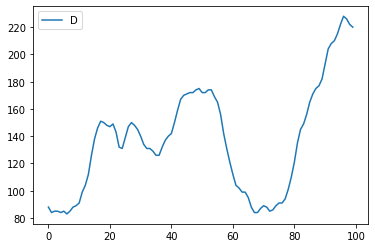

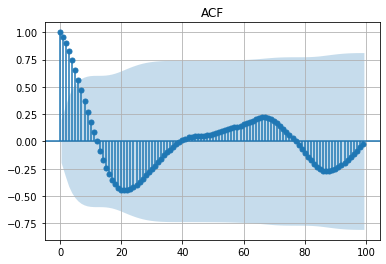

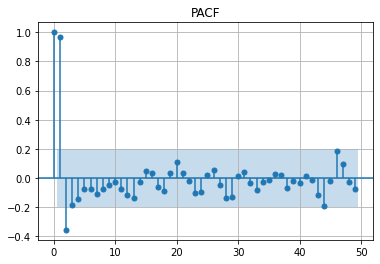

In [38]:
# Plotando dataset, e autocorrelações
plt.figure(figsize = (6,4))

plt.plot(df)
plt.legend('Data')

plot_acf(df, title='ACF', lags = 99)
plt.grid()

plot_pacf(df, title='PACF', lags = 49)
plt.grid()

plt.show()

### Visualizando fator de diferenciação (_d_ = 1 e _d_ = 2)

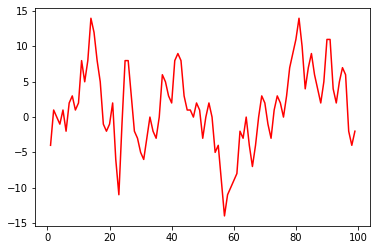

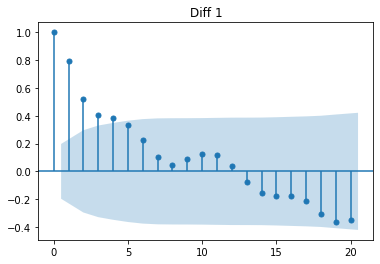

In [42]:
#fator de diferenciação = 1
df_1 = df.diff() #value(t) = (t-1) - (t)

plt.figure(figsize = (6,4))
plt.plot(df_1, color = 'red')
plot_acf(df_1.value.dropna(), title='ACF - Diff 1')

plt.title('Diff 1')

plt.show()

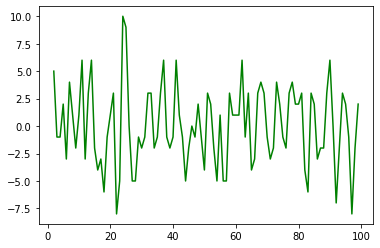

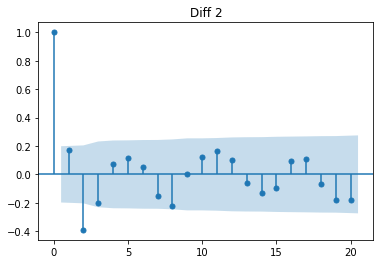

In [43]:
#fator de diferenciação = 2
df_2 = df.diff().diff() #value(t) = df_1.diff()

plt.figure(figsize=(6,4))
plt.plot(df_2, color = 'green')
plot_acf(df_2.value.dropna(), title='ACF - Diff 2')

plt.title('Diff 2')
plt.show()

O fator de diferenciação mais adequado é aquele onde, a autocorrelação entre os valores cai bruscamente a 0, então fixamos _d_ = 1 como primeira opção

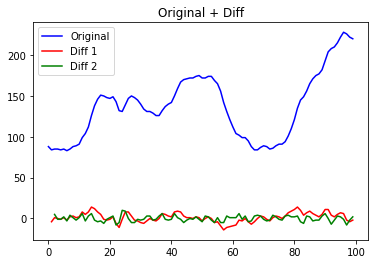

In [47]:
plt.figure(figsize = (6,4))

plt.plot(df, color = 'blue')
plt.plot(df_1, color = 'red')
plt.plot(df_2, color = 'green')

plt.legend(['Original','Diff 1','Diff 2'])

plt.title('Original + Diff')

plt.show()

### Selecionando ordem da auto regressão __AR(_p_)__ -> _p_ = ?

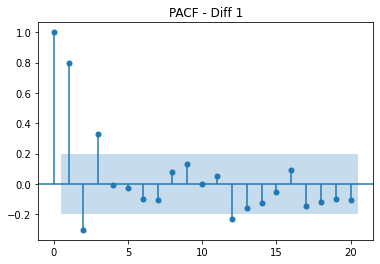

In [48]:
#Para selecionar o fator de AR basta plotar o gráfico de autocorrelação parcial
plot_pacf(df_1.value.dropna(), title='PACF - Diff 1')

plt.show()

Para _p_ = 1 o valor de PACF é significante, sendo assim foi fixado _p_ = 1

### Selecionando ordem da média móvel __MA(_q_)__  -> _q_ = ?

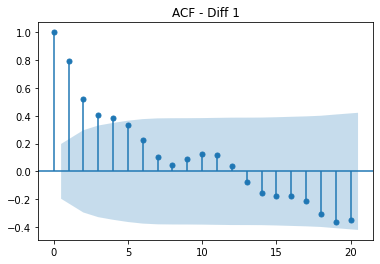

In [49]:
#Para selecionar a ordem q basta plotar o gráfico de autocorrelação 
plot_acf(df_1.value.dropna(), title='ACF - Diff 1')

plt.show()

Para _q_ entre 1 e 4 a ACF permanece acima da "linha de erro", será fixado _q_ = 1 

### Criando modelo ARIMA (1,1,1)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

arima = ARIMA(df.value, order=(1,1,1))

arima_fit = arima.fit()

In [58]:
#Verificando valores do modelo ARIMA
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Fri, 16 Oct 2020   AIC                            515.579
Time:                        11:11:58   BIC                            525.960
Sample:                             1   HQIC                           519.779
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1205      1.286      0.871      0.384      -1.400       3.641
ar.L1.D.value     0.6344      0.087      7.317      0.000       0.464       0.804
ma.L1.D.value     0.5297      0.089      5.932      0.000       0.355       0.705
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5764           +0.0000j            1.5764            0.0000
MA.1           -1.8879           +0.0000j            1.8879            0.5000
-----------------------------------------------------------------------------
"""

###### Informações importantes:

* Verificar o valor de coef na tabela do meio: coef é o coeficientes para os termos de AR e MA, é importante que não sejam muito próximos de 0, pois anularia os efeitos do modelo, caso sejam muito próximos de 0 podem ser descartados.
* O valor de P>|Z| deve ser o mais próximo possível de 0, P < 0.05 é uma boa indicação de estacionaridade

### Analisando valor real e valor obtido pelo modelo ARIMA(1,1,1)

In [61]:
#Prevendo valor
pred = arima_fit.predict(dynamic = False)

In [69]:
#Retornando valores preditos à escala inicial
res = df.value + pred

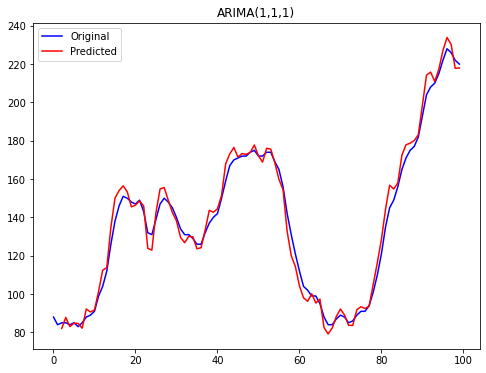

In [70]:
plt.figure(figsize=(8,6))

plt.plot(df, color='blue')
plt.plot(res, color = 'red')

plt.legend(['Original','Predicted'])
plt.title('ARIMA(1,1,1)')

plt.show()

### Avaliando modelo com dados de treino e teste

In [71]:
train = df[:80]
test = df[80:]

In [89]:
#criando modelo ARIMA com os mesmos parâmetros citados anteriormente
arima = ARIMA(train, order=(1,1,1))
arima_fit = arima.fit()

#O método forecast retorna 3 valores o que será utilizado é o primeiro - valores previstos 
forecast, val2, val3 = arima_fit.forecast(20) #prevendo os 20 últimos valores

forecast = pd.Series(forecast, index=test.index)

C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmode

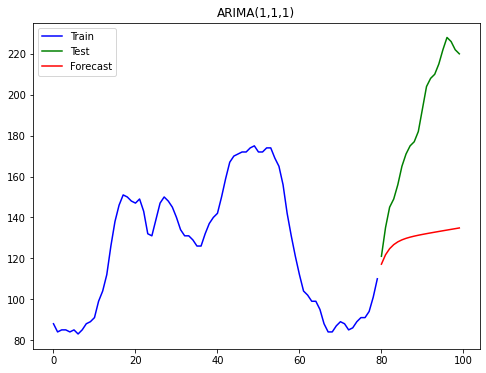

In [85]:
#Plotando valores

plt.figure(figsize=(8,6))

plt.plot(train, color='blue')
plt.plot(test, color ='green')
plt.plot(forecast, color = 'red')

plt.title('ARIMA(1,1,1)')
plt.legend(['Train','Test','Forecast'])

plt.show()

In [91]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test.value, forecast))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 62.825


### Testando melhor combinação ARIMA (p, d, q)

In [97]:
def arima_train(p, d, q):
    p = int(p)
    d = int(d)
    q = int(q)
    arima = ARIMA(train, order=(p,d,q))
    arima_fit = arima.fit()
    forecast, val2, val3 = arima_fit.forecast(20)
    forecast = pd.Series(forecast, index=test.index)
    return forecast

def get_rmse(test, forecast):
    return sqrt(mean_squared_error(test.value, forecast))

In [107]:
p_values = ['1','2','3','4','5']
d_values = ['1','2']
q_values = ['1','2']

params = []
error = []

for p in p_values:
    for d in d_values:
        for q in q_values:
            forecast = arima_train(p,d,q)
            rmse_val = get_rmse(test, forecast)
            error.append(rmse_val)
            param = 'P = '+p+' D = '+d+' Q = '+q
            params.append(param)

df_error = pd.DataFrame()
df_error['Params'] = params
df_error['Erro'] = error
df_error.head(15)

C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmode

C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmode

C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmode

C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are

C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
   

,Params,Erro
0,P = 1 D = 1 Q = 1,62.824640
1,P = 1 D = 1 Q = 2,64.578994
2,P = 1 D = 2 Q = 1,48.650296
3,P = 1 D = 2 Q = 2,70.707608
4,P = 2 D = 1 Q = 1,63.351920
5,P = 2 D = 1 Q = 2,66.193625
6,P = 2 D = 2 Q = 1,22.313566
7,P = 2 D = 2 Q = 2,15.575909
8,P = 3 D = 1 Q = 1,57.627701
9,P = 3 D = 1 Q = 2,60.678935


### Modelo criado baseado no menor erro quadrático médio (_p_, _d_, _q_) = (2, 2, 2)

C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmode

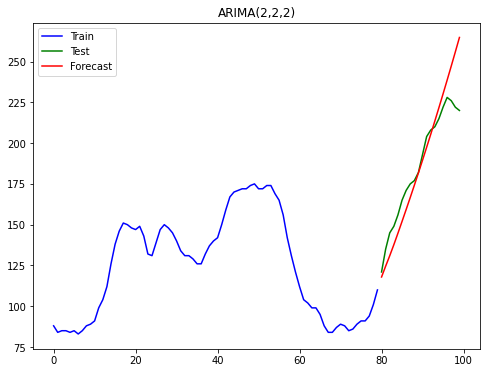

In [108]:
forecast = arima_train(2,2,2)

#Plotando valores

plt.figure(figsize=(8,6))

plt.plot(train, color='blue')
plt.plot(test, color ='green')
plt.plot(forecast, color = 'red')

plt.title('ARIMA(2,2,2)')
plt.legend(['Train','Test','Forecast'])

plt.show()

### Conlusão

O modelo ARIMA é uma junção dos modelos AR e MA capaz de tornar os dados estacionários para facilitar as previsões futuras. É importante analisar as correlações entre os valores e testar alguns deles para obter um resultado satisfatório.

As análises de autocorrelação são eficazes para criar uma linha de base a ser seguida, contudo ao treinar variações de parâmetros percebemos que a linha de base pode não ser a ideal